In [1]:
# ################
# Imports
# ################
from collections import namedtuple
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import default_collate

from jax import jit, lax, random
from jax.tree_util import tree_map
import jax.numpy as jnp
from jax.random import PRNGKey
from tqdm.notebook import tqdm

import numpyro
from numpyro import optim
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal


/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_18280/1703287709.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Generate Data

--- 

In [2]:

SEED=99
np.random.seed(SEED)
N = int(0.5e6)
beta = 2.5
alpha = -0.5
X = np.random.normal(0,1,size=N)
y = alpha + beta*X + np.random.normal(size=N)
pd_dataset = pd.DataFrame({"X":X, "y":y})
pd_dataset.head(10)

,X,y
0,-0.142359,-1.323454
1,2.057222,3.845432
2,0.283262,0.729401
3,1.329812,2.906906
4,-0.154622,0.395379
5,-0.069031,-1.535244
6,0.755180,2.202239
7,0.825647,-0.118247
8,-0.113069,0.866694
9,-2.367838,-7.469620


# Define Model

---

In [3]:
def model(X, y=None):
    beta = numpyro.sample("beta", dist.Normal(0,1))
    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    mu = alpha + beta*X
    
    obs = numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [4]:
# #################################
# summarize training results
# #################################

def plot_results(svi_result, guide, method='svi.run'):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].set(title="ELBO Loss",xlabel='Steps', ylabel='Loss')
    ax[0].plot( svi_result.losses )
    
    ax[1].set(title="Parameter Estimate",xlabel='Parameter Value')
    samples = guide.sample_posterior(PRNGKey(1), svi_result.params, (1000,))
    ax[1].hist( samples['alpha'], alpha=0.5 )
    ax[1].hist( samples['beta'], alpha=0.5 )
    ax[1].axvline(alpha, ls='--', label='True Alpha')
    ax[1].axvline(beta, ls='--', color='C1', label='True Beta')
    ax[1].legend()
    
    plt.suptitle(f"Fitted Model Results from {method}")

# Method 1: Train on all data in-memory

---

In [5]:
def train_on_all_data(model):
    optimizer = numpyro.optim.Adam(0.01)
    guide = AutoLowRankMultivariateNormal(
        model, init_loc_fn=numpyro.infer.init_to_median(), init_scale=0.025
    )

    data = pd_dataset

    svi = numpyro.infer.SVI(model, guide, optimizer, Trace_ELBO())
    svi_result = svi.run(PRNGKey(0), 1000, X=data.X.values, y=data.y.values)
    return svi_result, guide

100%|███████████████████| 1000/1000 [00:00<00:00, 1000.84it/s, init loss: 6104365.5000, avg. loss [951-1000]: 711655.7500]


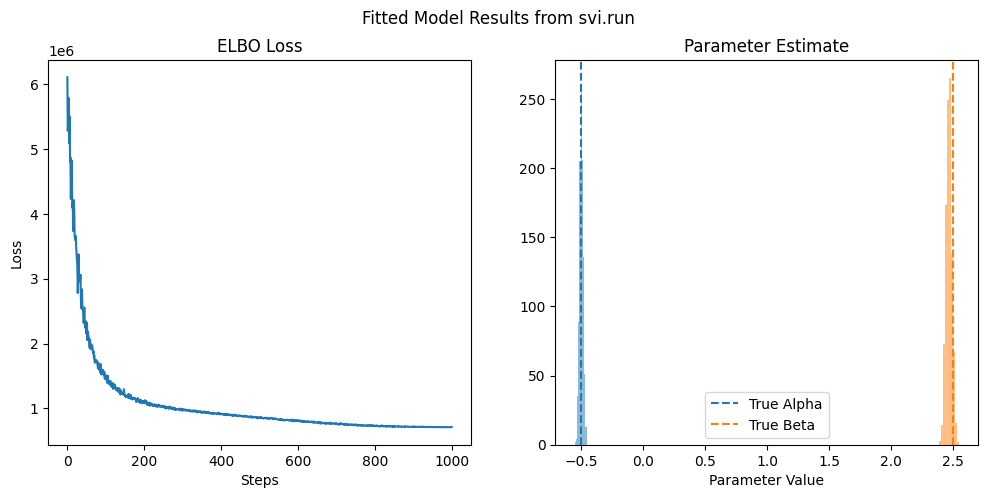

In [6]:
svi_result, guide = train_on_all_data(model)
plot_results(svi_result, guide)
plt.show()

This is reasonable and fast, but it requires all of the data to be load-able into memory

# Method 2: Train in batches

---

This approach is going to take a basic pytorch dataloader and run an `svi.update` operation on each batch

In [4]:
# #########################################################
# Create pytorch dataloader for training in batches
# #########################################################

class SimpleDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        vals = self.df.iloc[[idx]].values
        X, target = vals[:,0], vals[:,1]
        return X,target
        
def numpy_collate(batch):
    '''Collate function makes dataloader output be a numpy array, which is required for jax/numpyro
    '''
    return tree_map(np.asarray, default_collate(batch))

class NumpyLoader(DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

In [8]:
# #########################################################
# Define training procedure for training in batches
# #########################################################

def train_in_batches(model):
    SVIRunResult = namedtuple("SVIRunResult", ("params", "state", "losses"),)

    dataset= SimpleDataset(pd_dataset)
    data_loder = NumpyLoader(dataset, batch_size=1000, shuffle=True)

    # Define model fitting process
    optimizer = numpyro.optim.Adam(0.01)
    guide = AutoLowRankMultivariateNormal(model, init_loc_fn=numpyro.infer.init_to_median(), init_scale=0.025)
    svi = numpyro.infer.SVI(model, guide, optimizer, Trace_ELBO())

    # Set initial svi state
    sample_batch = next(iter(data_loder))
    svi_state = svi.init(PRNGKey(0), X=sample_batch[0], y=sample_batch[1])

    # Train
    losses = []
    for x,y in tqdm(data_loder):
        svi_state, loss = svi.update(svi_state, X=x, y=y)    
        losses.append(loss)

    svi_result = SVIRunResult(svi.get_params(svi_state), svi_state, losses)
    return svi_result, guide

  0%|          | 0/500 [00:00<?, ?it/s]

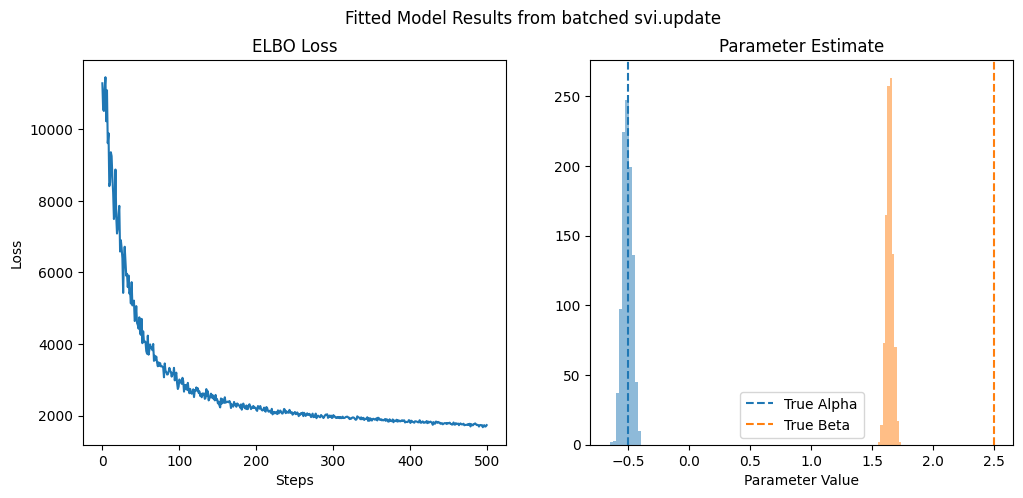

In [9]:
# Too slow
svi_result_batched, guide_batched = train_in_batches(model)
plot_results(svi_result_batched, guide_batched, method='batched svi.update')
plt.show()

This was slow, and the parameters didnt converge. The fitting algorithm works by taking small steps from an initial distribution towards an approximate posterior distribution for the parameters of interest. 

In this case, the data is being fed through in batches, and there's only 1 update step for each record in the dataset. Ideally, there should be multiple steps, much like `epochs` used in deep learning

Apparently, the log-likelihood needs to be properly scaled as well, but I haven't quite figured out _why_ under the hood. but the model below shows how to encode that in a plate

In [10]:
def model_subsample(X, y=None):
    total_dataset_size=N
    beta = numpyro.sample("beta", dist.Normal(0,1))
    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("n", total_dataset_size, subsample_size=X.shape[0]):
        mu = alpha + beta*X
        obs = numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

# Method 3: Adding epochs, `jit`-ing the update step

---

The training procedure below is almost identical to the previous method, but `svi.update` is wrapped with `jit` so it compiles just in time, and the concept of epochs are introduced

In [11]:
def train_in_batches_jit(model, num_epochs=10, batch_size=10_000):
    SVIRunResult = namedtuple("SVIRunResult", ("params", "state", "losses"),)

    dataset= SimpleDataset(pd_dataset)
    data_loader = NumpyLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define model fitting process
    optimizer = numpyro.optim.Adam(0.01)
    guide = AutoLowRankMultivariateNormal(model, init_loc_fn=numpyro.infer.init_to_median(), init_scale=0.025)
    svi = numpyro.infer.SVI(model, guide, optimizer, Trace_ELBO())
    jit_update = jit(svi.update)

    # Set initial svi state
    sample_batch = next(iter(data_loader))
    svi_state = svi.init(PRNGKey(0), X=sample_batch[0], y=sample_batch[1])
    
    # Train
    losses = []
    for _ in tqdm(range(num_epochs)):
        for x,y in data_loader:
            svi_state, loss = jit_update(svi_state, X=x, y=y)    
            losses.append(loss)

    svi_result = SVIRunResult(svi.get_params(svi_state), svi_state, losses)
    return svi_result, guide

/var/folders/vr/0jhy9tx52_s6tvbfbyppgn580000gn/T/ipykernel_18230/1701122240.py:15: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_state = svi.init(PRNGKey(0), X=sample_batch[0], y=sample_batch[1])


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/kylejcaron/Library/Caches/pypoetry/virtualenvs/numpyro-dataloaders-WUPW4sbv-py3.10/lib/python3.10/site-packages/jax/_src/linear_util.py:191: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


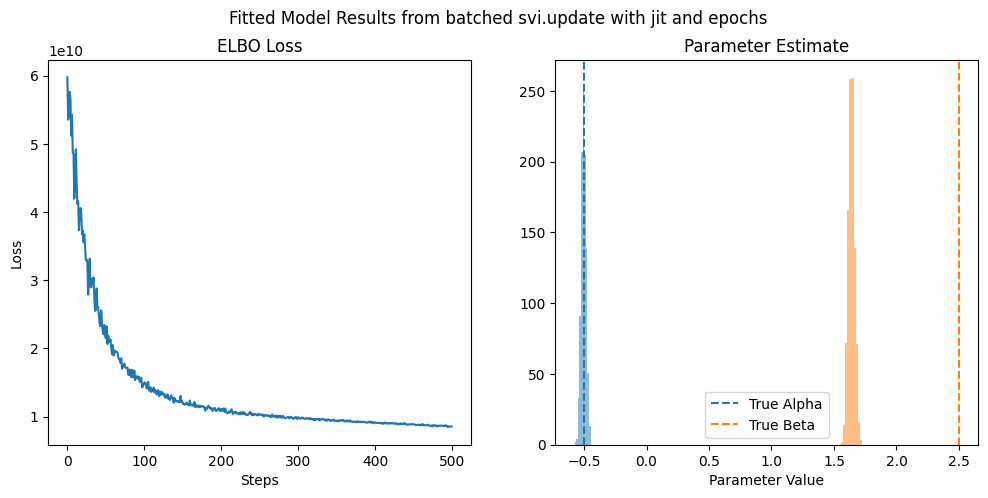

In [12]:
svi_result, guide = train_in_batches_jit(model_subsample, num_epochs=10)
plot_results(svi_result, guide, method='batched svi.update with jit and epochs')
plt.show()

This pattern is still too slow and it still didnt converge, however it is compatible with larger-than-memory datasets

# Method 4: Jax style data fetching

---

This is borrow from the [VAE example](https://github.com/pyro-ppl/numpyro/blob/9ce2384595975cd7a1b9a51402124c999ee0141a/examples/vae.py#L150C1-L151C1) - it is much faster, but it requires all of the data to be loaded into memory. 


In [13]:
num_records = len(pd_dataset)
idxs = np.arange(num_records)
arrays = jnp.array(pd_dataset['X']), jnp.array(pd_dataset['y'])
batch_size = 1000

In [14]:
def train_init(shuffle=False):
    return (
        num_records // batch_size,
        np.random.permutation(idxs) if shuffle else idxs,
    )

@jit
def get_batch(i=0, idxs=idxs):
    ret_idx = lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
    return tuple(
        np.take(a, ret_idx, axis=0)
        if isinstance(a, list)
        else lax.index_take(a, (ret_idx,), axes=(0,))
        for a in arrays
    )

In [15]:
def train_in_batches_jax(model, batch, num_epochs=10):
    SVIRunResult = namedtuple("SVIRunResult", ("params", "state", "losses"),)
    arrays = batch

    @jit
    def get_batch(arrays, i=0, idxs=idxs):
        ret_idx = lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return tuple(
            np.take(a, ret_idx, axis=0)
            if isinstance(a, list)
            else lax.index_take(a, (ret_idx,), axes=(0,))
            for a in arrays
        )

    # Define model fitting process
    rng_key = random.PRNGKey(0)
    optimizer = numpyro.optim.Adam(0.01)
    guide = AutoLowRankMultivariateNormal(model, init_loc_fn=numpyro.infer.init_to_median(), init_scale=0.025)
    svi = numpyro.infer.SVI(model, guide, optimizer, Trace_ELBO())

    # Set initial svi state
    rng_key, rng_key_init = random.split(rng_key, 2)
    num_train, train_idx = train_init()    
    sample_batch = get_batch(arrays, 0, train_idx)
    svi_state = svi.init(PRNGKey(0), X=sample_batch[0], y=sample_batch[1])

    @jit
    def epoch_train(svi_state, rng_key, batch, train_idx):
        def body_fn(i, val):
            loss_sum, svi_state = val
            batch_i = get_batch(batch, i, train_idx)
            svi_state, loss = svi.update(svi_state, X=batch_i[0], y=batch_i[1])
            loss_sum += loss
            return loss_sum, svi_state
        
        # Iterate through each batch and perform a fitting step
        return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state))
        
    # Train
    losses = []
    for i in tqdm(range(num_epochs)):
    
        # split keys
        rng_key, rng_key_train = random.split(rng_key, 2)
            
        num_train, train_idx = train_init(shuffle=False)    
        loss, svi_state = epoch_train(svi_state, rng_key_train, batch=arrays, train_idx=train_idx)
        losses.append(loss)


    svi_result = SVIRunResult(svi.get_params(svi_state), svi_state, losses)
    return svi_result, guide

  0%|          | 0/10 [00:00<?, ?it/s]

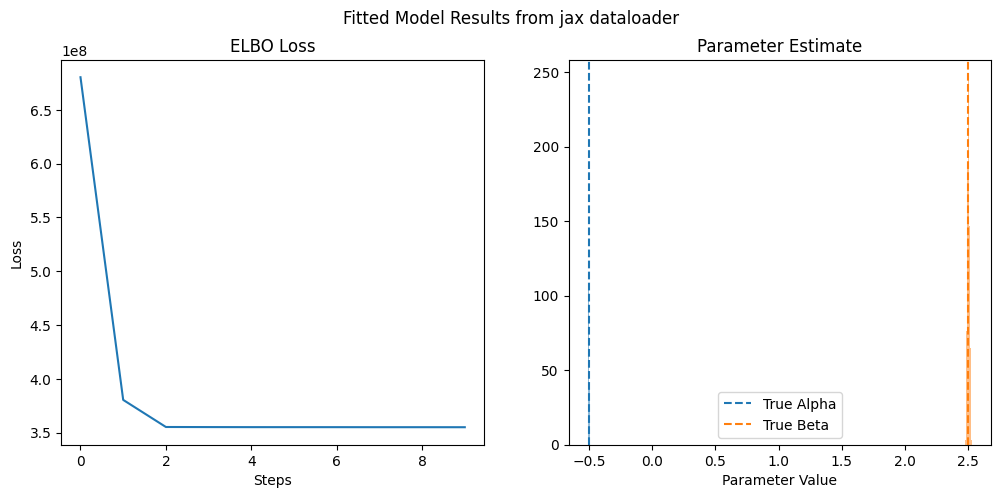

In [16]:
svi_result, guide = train_in_batches_jax(model_subsample, arrays, num_epochs=10)
plot_results(svi_result, guide, method='jax dataloader')

This was incredibly fast. A mix of these 2 ideas might be the best, where a large chunk is data-loaded with pytorch, and then iterated through with jax

# Method 5: Dataloader with Jax batching

In [17]:
def train_in_batches_jax2(model, num_epochs=10, batch_size=100_000, sub_batch_size=10_000):
    
    SVIRunResult = namedtuple("SVIRunResult", ("params", "state", "losses"),)
    rng_key = random.PRNGKey(0)
    
    dataset= SimpleDataset(pd_dataset)
    data_loader = NumpyLoader(dataset, batch_size=batch_size)

    # Define model fitting process
    optimizer = numpyro.optim.Adam(0.01)
    guide = AutoLowRankMultivariateNormal(model, init_loc_fn=numpyro.infer.init_to_median(), init_scale=0.025)
    svi = numpyro.infer.SVI(model, guide, optimizer, Trace_ELBO())

    # Set initial svi state
    rng_key, rng_key_init = random.split(rng_key, 2)

    sample_batch = next(iter(data_loader))
    svi_state = svi.init(rng_key_init, X=sample_batch[0][:sub_batch_size], y=sample_batch[1][:sub_batch_size])

    # dataloading
    idxs = jnp.arange(batch_size)
    num_train = batch_size // sub_batch_size

    @jit
    def get_batch(arrays, i=0, idxs=idxs):
        ret_idx = lax.dynamic_slice_in_dim(idxs, i * sub_batch_size, sub_batch_size)
        return tuple(
            np.take(a, ret_idx, axis=0)
            if isinstance(a, list)
            else lax.index_take(a, (ret_idx,), axes=(0,))
            for a in arrays
        )
        
    @jit
    def epoch_train(svi_state, rng_key, batch, train_idx):
        jit_update = jit(svi.update)
        def body_fn(i, val):
            loss_sum, svi_state = val
            batch_i = get_batch(batch, i, train_idx)
            svi_state, loss = jit_update(svi_state, X=batch_i[0], y=batch_i[1])
            loss_sum += loss
            return loss_sum, svi_state
        
        # Iterate through each batch and perform a fitting step
        return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state))

    
    # Train
    losses = []
    for _ in tqdm(range(num_epochs)):
        
        for batch in data_loader:
            # split keys
            rng_key, rng_key_train = random.split(rng_key, 2)
            loss, svi_state = epoch_train(svi_state, rng_key_train, batch=batch, train_idx=idxs)    
            losses.append(loss)

    svi_result = SVIRunResult(svi.get_params(svi_state), svi_state, losses)
    return svi_result, guide

In [21]:
# svi_result, guide = train_in_batches_jax2(model_subsample, num_epochs=10, batch_size=500_000, sub_batch_size=10_000)
# plot_results(svi_result, guide, method='pytorch dataloader with jax batching')

This is still very slow - when timing each piece of the operation, its the pytorch dataloader that is the bottleneck


This [article](https://huggingface.co/docs/datasets/about_mapstyle_vs_iterable) seems to suggest an `IterableDataset` may help with speed which I'll test next

In [22]:
from torch.utils.data import IterableDataset

class SimpleIterDataset(IterableDataset):
    def __init__(self, df, transform=None):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        vals = self.df.iloc[[idx]].values
        X, target = vals[:,0], vals[:,1]
        return X,target

    def __iter__(self):
        return iter(self.df.values)
        

In [25]:
def train_in_batches_jax3(model, num_epochs=10, batch_size=100_000, sub_batch_size=10_000):
    
    SVIRunResult = namedtuple("SVIRunResult", ("params", "state", "losses"),)
    rng_key = random.PRNGKey(0)
    
    dataset= SimpleIterDataset(pd_dataset)
    data_loader = NumpyLoader(dataset, batch_size=batch_size)

    # Define model fitting process
    optimizer = numpyro.optim.Adam(0.01)
    guide = AutoLowRankMultivariateNormal(model, init_loc_fn=numpyro.infer.init_to_median(), init_scale=0.025)
    svi = numpyro.infer.SVI(model, guide, optimizer, Trace_ELBO())

    # Set initial svi state
    rng_key, rng_key_init = random.split(rng_key, 2)

    sample_batch = next(iter(data_loader))
    svi_state = svi.init(rng_key_init, X=sample_batch[0][:sub_batch_size], y=sample_batch[1][:sub_batch_size])

    # dataloading
    idxs = jnp.arange(batch_size)
    num_train = batch_size // sub_batch_size

    @jit
    def get_batch(arrays, i=0, idxs=idxs):
        ret_idx = lax.dynamic_slice_in_dim(idxs, i * sub_batch_size, sub_batch_size)
        return tuple(
            np.take(a, ret_idx, axis=0)
            if isinstance(a, list)
            else lax.index_take(a, (ret_idx,), axes=(0,))
            for a in arrays
        )
        
    @jit
    def epoch_train(svi_state, rng_key, batch, train_idx):
        jit_update = jit(svi.update)
        def body_fn(i, val):
            loss_sum, svi_state = val
            batch_i = get_batch(batch, i, train_idx)
            svi_state, loss = jit_update(svi_state, X=batch_i[0], y=batch_i[1])
            loss_sum += loss
            return loss_sum, svi_state
        
        # Iterate through each batch and perform a fitting step
        return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state))

    
    # Train
    losses = []
    for _ in tqdm(range(num_epochs)):
        
        for batch in data_loader:
            batch = tuple((batch[:,0], batch[:,1],))
            # split keys
            rng_key, rng_key_train = random.split(rng_key, 2)
            loss, svi_state = epoch_train(svi_state, rng_key_train, batch=batch, train_idx=idxs)    
            losses.append(loss)

    svi_result = SVIRunResult(svi.get_params(svi_state), svi_state, losses)
    return svi_result, guide

  0%|          | 0/20 [00:00<?, ?it/s]

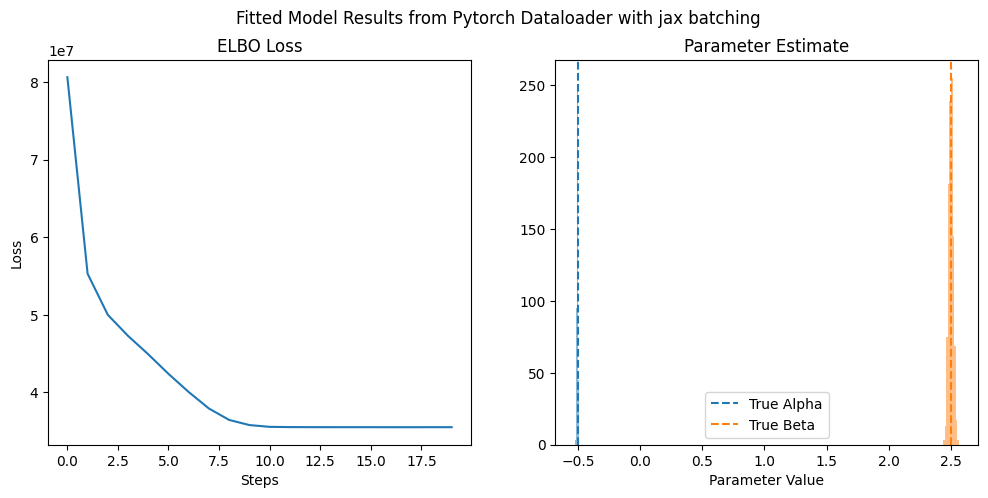

In [26]:
svi_result, guide = train_in_batches_jax3(model_subsample, num_epochs=20, batch_size=500_000, sub_batch_size=10_000)
plot_results(svi_result, guide, method='Pytorch Dataloader with jax batching')


This seems to be the most promising approach - it should work with larger than memory datasets and is definitely quick enough. Next steps might be testing this on a much larger dataset that exists out of memory